<a href="https://colab.research.google.com/github/LeRoiBof/ML-Project/blob/main/ML1_Project_T4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project - Machine Learning - Gradient Boosting Regression with XGBoost

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

## Data loading


In [25]:
df_train = pd.read_csv('train.csv')

excluded_columns = ['Utilities', 'Condition1', 'Condition2', 'HouseStyle', 'YearBuilt',
       'YearRemodAdd', 'Exterior1st', 'Exterior2nd', 'ExterCond', 'Foundation',
       'BsmtCond', 'BsmtFinType2', 'BsmtUnfSF', 'HeatingQC', 'CentralAir',
       '2ndFlrSF', 'LowQualFinSF', 'BsmtHalfBath', 'HalfBath', 'KitchenAbvGr',
       'GarageYrBlt', 'GarageFinish', 'PavedDrive', 'EnclosedPorch',
       '3SsnPorch', 'Fence', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition']

for element in excluded_columns:
  df_train=df_train.drop(columns=element)

#Outlier
#Overfiting avec outlier
'''
for element in df_train.select_dtypes(include=['int64', 'float64']).columns:

  max_threshold = df_train[element].quantile(0.9)
  min_threshold = df_train[element].quantile(0.1)

  outliers = (df_train[element] > max_threshold) | (df_train[element] < min_threshold)

  # Remplacer les valeurs aberrantes par la moyenne des valeurs non aberrantes
  df_train.loc[outliers, element] = df_train[~outliers][element].mean()
'''

y = df_train['LotArea']
X = df_train.drop(columns='LotArea')

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_test = pd.read_csv('test.csv')
X_test_id = X_test['ID']
X_test = X_test.drop(columns='ID')

df_train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,ScreenPorch,PoolArea,PoolQC,MiscVal
0,120,RM,NaN,4438,Pave,NaN,Reg,Lvl,Inside,Gtl,...,2.0,420.0,TA,TA,140,0,0,0,NaN,0
1,20,RL,66.0,8300,Pave,NaN,IR1,Lvl,Inside,Gtl,...,1.0,288.0,TA,TA,0,0,0,0,NaN,0
2,60,RL,74.0,9056,Pave,NaN,IR1,Lvl,Inside,Gtl,...,2.0,403.0,TA,TA,100,35,0,0,NaN,0
3,90,RL,70.0,8078,Pave,NaN,Reg,Lvl,Inside,Gtl,...,2.0,484.0,TA,TA,0,0,0,0,NaN,0
4,30,RM,50.0,5925,Pave,NaN,Reg,Bnk,Inside,Gtl,...,2.0,672.0,TA,TA,0,72,0,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,60,RL,82.0,9430,Pave,NaN,Reg,Lvl,Inside,Gtl,...,3.0,856.0,TA,TA,0,128,180,0,NaN,0
1455,20,RL,60.0,9600,Pave,NaN,Reg,Lvl,Inside,Gtl,...,2.0,436.0,TA,TA,290,0,0,0,NaN,0
1456,160,RL,24.0,2308,Pave,NaN,Reg,Lvl,FR2,Gtl,...,2.0,440.0,TA,TA,108,0,0,0,NaN,0
1457,20,RL,61.0,33983,Pave,NaN,IR1,Lvl,Inside,Gtl,...,2.0,672.0,TA,TA,690,90,0,0,NaN,0


## Preprocessing

In [3]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

print(numeric_features)
print(categorical_features)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])




Index(['MSSubClass', 'LotFrontage', 'OverallQual', 'OverallCond', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea',
       'BsmtFullBath', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')
Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig',
       'LandSlope', 'Neighborhood', 'BldgType', 'RoofStyle', 'RoofMatl',
       'MasVnrType', 'ExterQual', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1',
       'Heating', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageQual', 'GarageCond', 'PoolQC'],
      dtype='object')


In [30]:

#Trouver les valeurs à supprimer dans le dataframe
df = df_train.copy()
for feature in categorical_features:
  df[feature] = df[feature].astype("category").cat.codes

corr  = df.corr()
lot_corr = corr[["LotArea"]]

data_to_delete = lot_corr[lot_corr > -0.05]
data_to_delete = data_to_delete[data_to_delete < 0.05]

data_to_delete = data_to_delete.dropna()

print(data_to_delete.index)
df_train

Index([], dtype='object')


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,ScreenPorch,PoolArea,PoolQC,MiscVal
0,120,RM,NaN,4438,Pave,NaN,Reg,Lvl,Inside,Gtl,...,2.0,420.0,TA,TA,140,0,0,0,NaN,0
1,20,RL,66.0,8300,Pave,NaN,IR1,Lvl,Inside,Gtl,...,1.0,288.0,TA,TA,0,0,0,0,NaN,0
2,60,RL,74.0,9056,Pave,NaN,IR1,Lvl,Inside,Gtl,...,2.0,403.0,TA,TA,100,35,0,0,NaN,0
3,90,RL,70.0,8078,Pave,NaN,Reg,Lvl,Inside,Gtl,...,2.0,484.0,TA,TA,0,0,0,0,NaN,0
4,30,RM,50.0,5925,Pave,NaN,Reg,Bnk,Inside,Gtl,...,2.0,672.0,TA,TA,0,72,0,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,60,RL,82.0,9430,Pave,NaN,Reg,Lvl,Inside,Gtl,...,3.0,856.0,TA,TA,0,128,180,0,NaN,0
1455,20,RL,60.0,9600,Pave,NaN,Reg,Lvl,Inside,Gtl,...,2.0,436.0,TA,TA,290,0,0,0,NaN,0
1456,160,RL,24.0,2308,Pave,NaN,Reg,Lvl,FR2,Gtl,...,2.0,440.0,TA,TA,108,0,0,0,NaN,0
1457,20,RL,61.0,33983,Pave,NaN,IR1,Lvl,Inside,Gtl,...,2.0,672.0,TA,TA,690,90,0,0,NaN,0


# Analysing

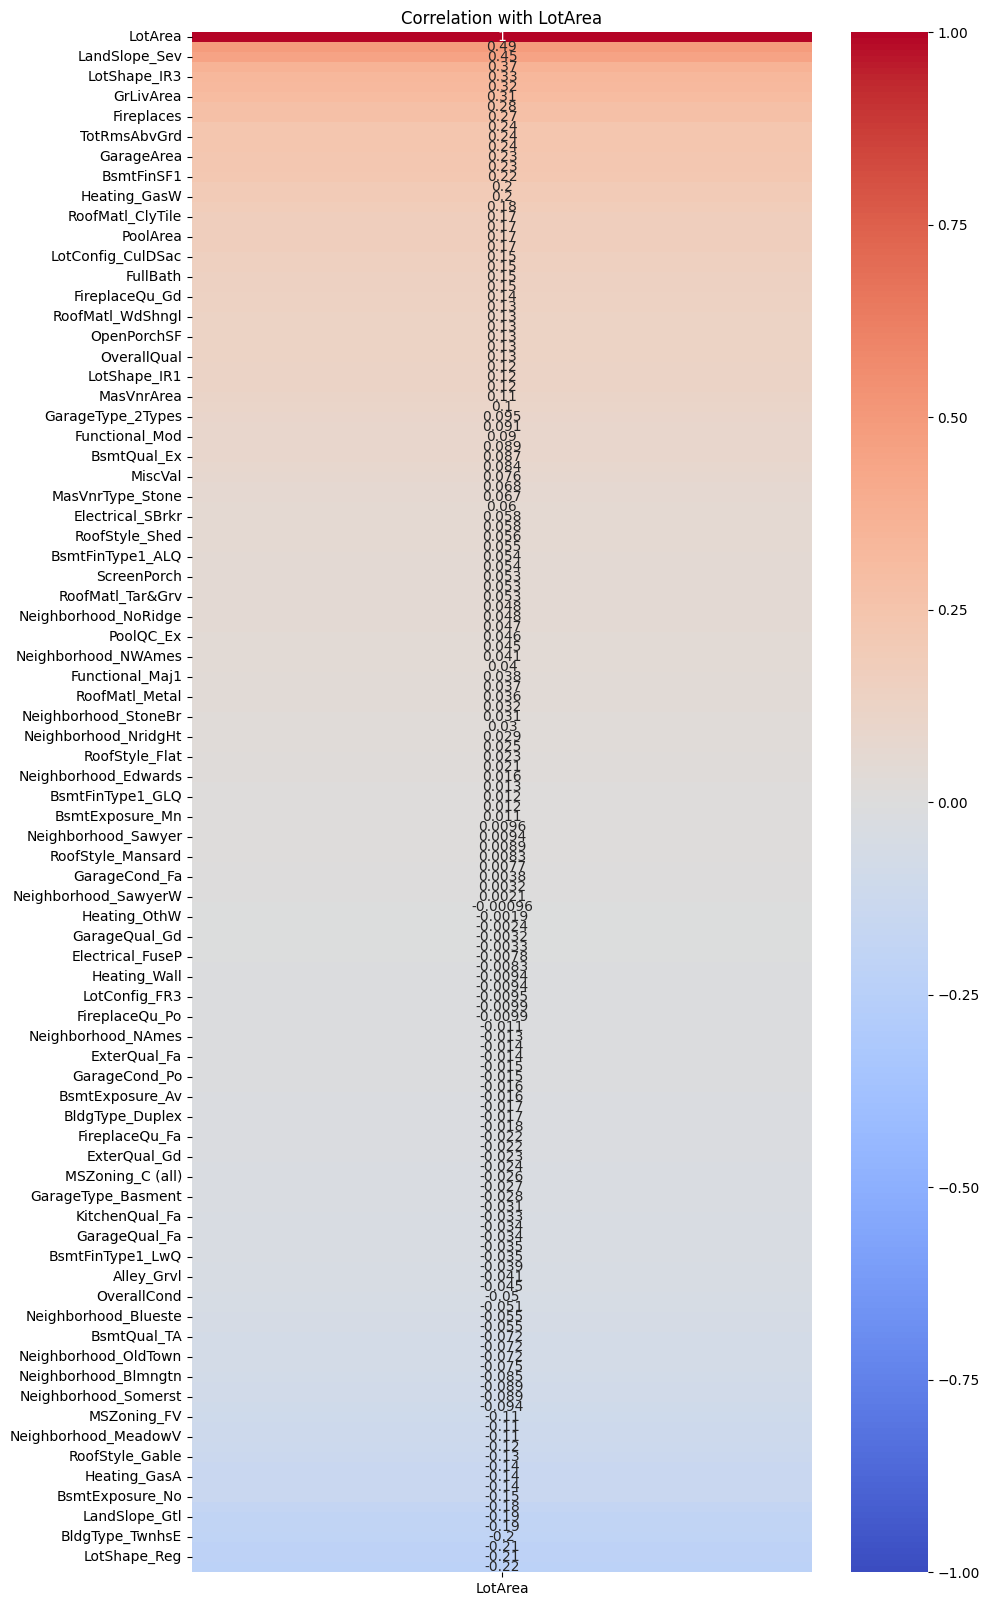

In [29]:
encoded_df = pd.get_dummies(df_train)

# Correlation VS LotArea
corr = encoded_df.corr()

sorted_corr = corr['LotArea'].sort_values(ascending=False)

plt.figure(figsize=(10, 20))
sns.heatmap(sorted_corr.to_frame(), cmap='coolwarm', annot=True, vmin=-1, vmax=1)
plt.title('Correlation with LotArea')
plt.show()

## Searching for the best hyperparameters

In [ ]:
model = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', GradientBoostingRegressor(random_state=42))])
# Définition de la grille des hyperparamètres à rechercher
param_grid = {
    'regressor__n_estimators': [100, 500, 1000],
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__max_depth': [3, 5, 7],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

# Recherche des meilleurs hyperparamètres
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Affichage des meilleurs hyperparamètres
print("Best parameters found:", grid_search.best_params_)

# Prédiction sur l'ensemble de validation
y_pred = grid_search.predict(X_val)

# Calcul du RMSE
rmse = mean_squared_error(y_val, y_pred, squared=False)
print("Root Mean Squared Error (RMSE) on validation set:", rmse)

In [5]:
model = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', GradientBoostingRegressor(random_state=42))])
# Définition de la grille des hyperparamètres à rechercher
param_grid = {
    'regressor__n_estimators': [100, 500, 1000],
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__max_depth': [3, 5, 7],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

# Recherche des meilleurs hyperparamètres
grid_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, cv=10, scoring='neg_mean_squared_error', n_iter=10)
grid_search.fit(X_train, y_train)

# Affichage des meilleurs hyperparamètres
print("Best parameters found:", grid_search.best_params_)

# Prédiction sur l'ensemble de validation
y_pred = grid_search.predict(X_val)

# Calcul du RMSE
rmse = mean_squared_error(np.log(y_val), np.log(y_pred), squared=False)
print("Root Mean Squared Error (RMSE) on validation set:", rmse)

Best parameters found: {'regressor__n_estimators': 500, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 1, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.1}
Root Mean Squared Error (RMSE) on validation set: 0.23650604974780634


c:\Users\maxim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Fitting and prediction

In [6]:
final_model = grid_search.best_estimator_
final_model.fit(X, y)
y_test = final_model.predict(X_test)


## Submission

In [153]:
submission = pd.DataFrame({
    'ID': X_test_id,
    'LotArea': y_test
})
submission.to_csv('submissionXGB.csv', index=False)
submission

,ID,LotArea
0,0,7642.099795
1,1,8588.034211
2,2,9979.775271
3,3,15207.931725
4,4,12076.015855
...,...,...
1455,1455,8249.002059
1456,1456,7278.356248
1457,1457,10227.345487
1458,1458,7970.674760
